In [1]:
import pandas as pd
import numpy as np

import neologdn
import MeCab

import re

import gensim
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

C:\Users\Tomori kengo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 日誌サンプルデータの読み込み

In [2]:
#encoding='utf-8'で上手くいった
diary_df = pd.read_csv('MFUG_Financial_statement_201803.csv', encoding='utf-8')

In [3]:
diary_df

,text
0,当年度の金融経済環境でありますが、世界経済は、米国の新政権の政策運営や欧州主要国の国政選挙、...
1,米国では、雇用・所得環境の改善に企業の生産活動の持ち直しも加わり、自律的な景気の拡大が続きま...
2,欧州も、英国のＥＵ離脱を巡る不透明感を内在しつつも、良好な雇用・所得環境や低金利等を支えに景...
3,アジアにおいても、先進国の景気拡大に伴う輸出の回復や旺盛なインフラ需要等を支えに、 ＡＳＥＡ...
4,こうした中、我が国経済も、東京都議会議員選挙や衆議院議員総選挙等を巡り 政治が揺れ動く展開と...
5,企業部門では、高水準の企業収益に在庫調整の一巡を受けた生産 の持ち直しも加わり、設備投資の高...
6,家計部門でも、企業の旺盛な採用意欲に支えられた良好 な雇用・所得環境を背景に、個人消費が底堅...
7,加えて、政府による大規模な経済対策の実施も年度 前半にかけての景気を押し上げました。
8,金融情勢に目を転じますと、第３四半期までは、ドル円相場は横這い圏で推移し、世界経済の回復を支...
9,金利については、米国において平成29年６月と12月及び平成30年３ 月に利上げが行われ、ユー...


### MeCabにかける前準備としてneologdn.normalize()を使用して文章全体を正規化

In [4]:
def get_diary_normalization(text):
    diary_normalization = neologdn.normalize(text)
    return diary_normalization

### MeCab + neologdで形態素解析し、名詞、形容詞原形と動詞原形を抽出しリストに格納
##### 参考：https://github.com/kujirahand/book-mlearn-gyomu/blob/master/src/ch4/Doc2Vec/create_model.py

In [5]:
neologd_tagger = MeCab.Tagger('-Ochasen -d C:\mecab-ipadic-neologd')

# 引数のテキストを分かち書きして配列にする
# node.surface: 文字のみ取得できる 出力例：同  期間  の  SBI  証券
# node.feature: 品詞、原形などの詳細を取得できる:「品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音」の順
# よって、「品詞」を取得したい場合はnode.featureをsplit()でリスト型にした後に抽出したい詳細のインデックス番号[0]を指定すればよい
# また、動詞や形容詞の「原形（の単語）」を取得したい場合はインデックス番号[6]を指定すればよい

def split_words(diary_normalization):
    node = neologd_tagger.parseToNode(diary_normalization) #parseだとエラー「 'str' object has no attribute 'feature'」
    wakati_words = []
    while node is not None:
        hinshi = node.feature.split(",")[0]
        if  hinshi in ["名詞"]:
            wakati_words.append(node.surface)
        elif hinshi in ["動詞", "形容詞"]:
            wakati_words.append(node.feature.split(",")[6])
        node = node.next
    return wakati_words

In [6]:
wakati_list = []

# 文章の上から順に作成した関数を実行
for diary in diary_df['text']:
    diary_normalization = get_diary_normalization(diary)
    wakati_words = split_words(diary_normalization)
    wakati_list.append(wakati_words)
    
wakati_list

[['当年度',
  '金融経済',
  '環境',
  '世界経済',
  '米国',
  '新政権',
  '政策',
  '運営',
  '欧州',
  '主要',
  '国',
  '国政選挙',
  '中東',
  '北朝鮮情勢',
  '緊張',
  '政策',
  '地政学',
  'リスク',
  'さらす',
  'れる',
  '景気',
  '面',
  '安定',
  'する',
  '回復',
  '拡大',
  '続く'],
 ['米国',
  '雇用',
  '所得',
  '環境',
  '改善',
  '企業',
  '生産',
  '活動',
  '持ち直し',
  '加わる',
  '自律',
  '的',
  '景気',
  '拡大',
  '続く'],
 ['欧州',
  '英国',
  'EU離脱',
  '巡る',
  '不透明感',
  '内在',
  'する',
  '良好',
  '雇用',
  '所得',
  '環境',
  '金利',
  '等',
  '支え',
  '景気',
  '底堅い',
  'さ',
  '維持',
  'する'],
 ['アジア',
  '先進国',
  '景気拡大',
  '伴う',
  '輸出',
  '回復',
  '旺盛',
  'インフラ',
  '需要',
  '等',
  '支え',
  'ASEAN',
  '東南アジア諸国連合',
  'NIEs',
  '新興工業経済地域',
  'はもと',
  '構造',
  '調整',
  '重石',
  '抱える',
  '中国',
  '景気',
  '堅調',
  '推移',
  '示す'],
 ['中',
  '我が国',
  '経済',
  '東京都議会議員選挙',
  '衆議院議員総選挙',
  '等',
  '巡る',
  '政治',
  '揺れ動く',
  '展開',
  'なる',
  '景気',
  '面',
  '景気',
  '拡張',
  '期間',
  'いざなぎ景気',
  '超える',
  '戦後',
  '2位',
  '達する',
  '等',
  '年度',
  '緩やか',
  '拡大',
  '続く'],
 ['企業',
  '部門',
  '高水準',
  '企業',
  '収益

# 辞書作成
### gensimで使う辞書の作成には、gensim.corpora.Dictionary関数を使う
### gensimの辞書は「単語ID・単語・単語出現回数」を持つデータ

In [7]:
dictionary = gensim.corpora.Dictionary(wakati_list)
# [辞書名].save_as_text('ファイル名.txt')で作成辞書を保存することができる
# 参考URL：https://qiita.com/u6k/items/5170b8d8e3f41531f08a
dictionary.save_as_text('Financial_statement_dictionary.txt')

In [8]:
# 保存した辞書の読み込み
with open('Financial_statement_dictionary.txt', 'r', encoding='utf-8') as f:
    dic = f.read()

print(dic)# gensimの辞書は「単語ID・単語・単語出現回数」を持つデータ

18
175	1	2
133	12月	1
134	1月	1
197	2	2
151	2017年度	1
188	278	1
69	2位	1
176	3	1
198	328	1
228	3兆円	1
135	3月	1
136	4月	1
152	500億円	1
177	542	1
178	575	1
218	5兆円	1
219	6	1
153	632	1
137	6月	1
179	8	1
199	854	1
154	896	2
155	9	2
48	ASEAN	1
36	EU離脱	1
49	NIEs	1
202	ある	1
70	いざなぎ景気	1
165	いる	1
37	さ	1
0	さらす	1
1	する	7
71	なる	7
50	はもと	1
229	みせる	1
96	られる	1
2	れる	2
51	アジア	1
203	アバディーン	1
52	インフラ	1
110	インフレ	1
111	ドル円	1
230	ベース	1
204	マイナス	1
166	モルガン・スタンレー	2
138	ユーロ圏	1
3	リスク	1
87	一巡	1
139	一方	1
205	一過性	1
156	上回る	2
112	上昇基調	1
113	不確実性	1
38	不透明感	1
206	与信関係費用	1
4	世界経済	2
72	中	1
53	中国	1
5	中東	1
180	主因	2
6	主要	2
189	人件費	1
167	他	1
207	以下	1
26	企業	3
54	伴う	2
88	伸び	2
140	低位	1
97	個人消費	1
157	億	5
181	兆	2
208	先	1
55	先進国	1
168	全て	1
39	内在	1
158	円	5
114	円高	1
209	出資	1
141	利上げ	1
169	利益	3
103	前半	1
159	前年度	4
104	加える	1
27	加わる	2
7	北朝鮮情勢	1
89	収益	1
90	受ける	1
115	台頭	1
210	合併	1
190	営業	1
8	回復	3
9	国	1
182	国内	1
10	国政選挙	1
116	圏	1
91	在庫	1
11	地政学	1
56	堅調	1
191	増加	3
160	増益	1
105	大規模	1
170	好調	1
171	子会社	1
12	安定	1
106	実施	2
231	実質	1
98	家計	1
192	対応	1
107

# コーパス作成
### gensimのコーパスは文章ごとに「単語ID・出現頻度」タプル配列を持つデータ

In [9]:
corpus = [dictionary.doc2bow(wakati) for wakati in wakati_list]

gensim.corpora.MmCorpus.serialize('Financial_statement_corpus.txt', corpus)

corpus[0]# 出力結果は[(単語のindex, 出現回数), …]となる、インデックス0番目の文章のコーパスを出力

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 2),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1)]

# LDAモデルの構築

In [10]:
# トピック数を指定
topics = 5
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=topics, id2word=dictionary)
# これで、トピック分析を行う準備が完了

In [11]:
# トピックが0~4の5個あり、トピックは単語・適合度の組み合わせで構築されていることがわかる
print(lda.show_topics())

[(0, '0.022*"億" + 0.019*"する" + 0.016*"増加" + 0.016*"利益" + 0.016*"他" + 0.016*"主要" + 0.016*"貢献" + 0.016*"モルガン・スタンレー" + 0.016*"好調" + 0.016*"子会社"'), (1, '0.022*"する" + 0.021*"等" + 0.019*"伴う" + 0.018*"巡る" + 0.015*"景気" + 0.015*"支え" + 0.013*"なる" + 0.010*"円" + 0.010*"億" + 0.010*"モルガン・スタンレー"'), (2, '0.037*"円" + 0.034*"億" + 0.030*"なる" + 0.028*"比" + 0.025*"増加" + 0.021*"前年度" + 0.021*"海外" + 0.017*"減少" + 0.015*"1" + 0.012*"主因"'), (3, '0.027*"景気" + 0.027*"企業" + 0.020*"続く" + 0.020*"環境" + 0.014*"推移" + 0.014*"拡大" + 0.014*"する" + 0.014*"旺盛" + 0.014*"調整" + 0.014*"所得"'), (4, '0.038*"れる" + 0.028*"する" + 0.027*"平成29年" + 0.026*"平成30年" + 0.016*"米国" + 0.015*"推移" + 0.015*"続く" + 0.014*"買入" + 0.014*"4月" + 0.014*"資産"')]


In [12]:
# ただのprint文だと出力が見辛いのでfor文を使用
for i in range(0, topics):
    print(lda.show_topics()[i])
    
print('---------------------------------------------------------------------------------------------------------------------------------------------------')   

# lda.show_topics()がlist型のため上記のようなコードをわざわざ記述する必要なく出力できる
for topics in lda.show_topics():
    print(topics)

(0, '0.022*"億" + 0.019*"する" + 0.016*"増加" + 0.016*"利益" + 0.016*"他" + 0.016*"主要" + 0.016*"貢献" + 0.016*"モルガン・スタンレー" + 0.016*"好調" + 0.016*"子会社"')
(1, '0.022*"する" + 0.021*"等" + 0.019*"伴う" + 0.018*"巡る" + 0.015*"景気" + 0.015*"支え" + 0.013*"なる" + 0.010*"円" + 0.010*"億" + 0.010*"モルガン・スタンレー"')
(2, '0.037*"円" + 0.034*"億" + 0.030*"なる" + 0.028*"比" + 0.025*"増加" + 0.021*"前年度" + 0.021*"海外" + 0.017*"減少" + 0.015*"1" + 0.012*"主因"')
(3, '0.027*"景気" + 0.027*"企業" + 0.020*"続く" + 0.020*"環境" + 0.014*"推移" + 0.014*"拡大" + 0.014*"する" + 0.014*"旺盛" + 0.014*"調整" + 0.014*"所得"')
(4, '0.038*"れる" + 0.028*"する" + 0.027*"平成29年" + 0.026*"平成30年" + 0.016*"米国" + 0.015*"推移" + 0.015*"続く" + 0.014*"買入" + 0.014*"4月" + 0.014*"資産"')
---------------------------------------------------------------------------------------------------------------------------------------------------
(0, '0.022*"億" + 0.019*"する" + 0.016*"増加" + 0.016*"利益" + 0.016*"他" + 0.016*"主要" + 0.016*"貢献" + 0.016*"モルガン・スタンレー" + 0.016*"好調" + 0.016*"子会社"')
(1, '0.022*"する" + 0.

## WordCloudによるトピックの可視化

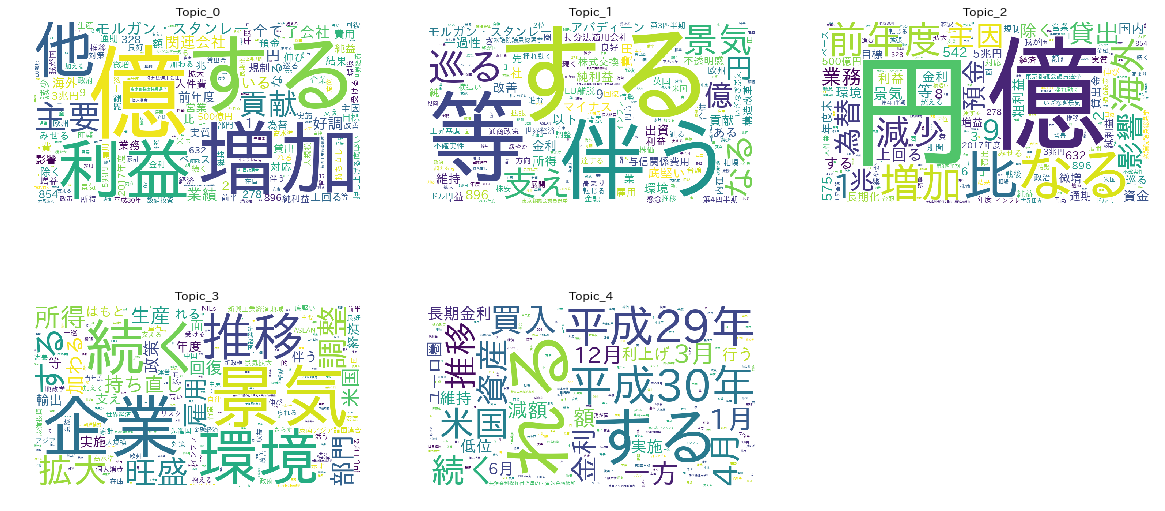

In [13]:
# 単語の大きさがその単語のそのトピックにおける所属確率の高さと対応
# 参考URL：https://www.sejuku.net/blog/67863
from wordcloud import WordCloud
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,20))
for t in range(lda.num_topics):
    plt.subplot(4,3,t+1)# plt.subplot(行数, 列数, 何番目のプロットか) この「行数」を調整して出力時の余白の幅を調整
    x = dict(lda.show_topic(t,200))
    # show_topic(topicid, topn=10) 
    # topn (int, optional) : Number of the most significant words that are associated with the topic.
    # つまり、topn=トピックに関係がある単語の数を設定、係数の大きな単語から設定した数だけ抽出される
    # 参考URL（公式ページ）：https://radimrehurek.com/gensim/models/ldamodel.html
    
    # WordCloudの引数のfont_pathの設定から行う これをしないと日本語文字化けが発生する
    # C:\Users\xxx\Anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf の中にある「ipaexg.ttf」をC:\Windows\Fonts ディレクトリの中に格納してから実行する
    fpath = r"C:\Windows\Fonts\ipaexg.ttf"
    im = WordCloud(background_color="white",font_path=fpath, width=900, height=500).generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Topic_" + str(t))